## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.

In [1]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [0]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [4]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.31 s, sys: 33 ms, total: 1.34 s
Wall time: 1.34 s


In [0]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [6]:
TEXT.vocab.freqs.most_common(10)

[('the', 224639),
 ('a', 112123),
 ('and', 110680),
 ('of', 100656),
 ('to', 93582),
 ('is', 72530),
 ('in', 62991),
 ('i', 49370),
 ('this', 48697),
 ('that', 46271)]

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        # we don't need to specify sort_key because it is set implicitly in Example object
        sort_within_batch=False,
        device='cuda',
#         device='cpu',
        repeat=False
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [0]:
len(TEXT.vocab)

202820

In [0]:
batch = next(train_iter.__iter__()); batch.text

tensor([[  29,   50,    9,  ...,    9,  572,    9],
        [  81, 1166,   14,  ...,  456,   50,  199],
        [  10,   47, 2418,  ...,  199,    3,   10],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [0]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [0]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=False)
        self.linear = nn.Linear(hidden_dim, 1)
            
    def forward(self, seq):
        embeddings = self.emb(seq)
        last_hidden = self.rnn(embeddings)[1]
        # preds are outputs of linear layer BEFORE sigmoid
        preds = self.linear(last_hidden).reshape(-1)
        return preds

In [0]:
em_sz = 200
nh = 300
model = RNNBaseline(nh, emb_dim=em_sz); model

RNNBaseline(
  (emb): Embedding(202820, 200)
  (rnn): GRU(200, 300)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

If you're using a GPU, remember to call model.cuda() to move your model to the GPU.

In [0]:
model.cuda()

RNNBaseline(
  (emb): Embedding(202820, 200)
  (rnn): GRU(200, 300)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

### The training loop (3 points)

Define the optimization and the loss functions.

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

Define the stopping criteria.

In [0]:
epochs = 25

In [0]:
def train_loop():
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() 
        for batch in train_iter:           
            x = batch.text
            y = batch.label

            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y.float())
            loss.backward()
            opt.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trn)
        train_loss_history.append(epoch_loss)

        val_loss = 0.0
        model.eval()
        for batch in val_iter:
            x = batch.text
            y = batch.label

            preds = model(x) 
            loss = loss_func(preds, y.float())
            val_loss += loss.item()
          
        val_loss /= len(vld)
        valid_loss_history.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
          epoch, epoch_loss, val_loss))

In [0]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop()

Epoch: 1, Training Loss: 0.010951032982553755, Validation Loss: 0.010909023213386536
Epoch: 2, Training Loss: 0.01079215990134648, Validation Loss: 0.010746264251073202
Epoch: 3, Training Loss: 0.009350192928314209, Validation Loss: 0.008579478259881337
Epoch: 4, Training Loss: 0.004811991492339543, Validation Loss: 0.007020445138216019
Epoch: 5, Training Loss: 0.0019441222961992025, Validation Loss: 0.008584113729000092
Epoch: 6, Training Loss: 0.0007047856861991541, Validation Loss: 0.010602376333872477
Epoch: 7, Training Loss: 0.00037709978071174454, Validation Loss: 0.012323990674813589
Epoch: 8, Training Loss: 0.00016102776816447398, Validation Loss: 0.015453861232598622
Epoch: 9, Training Loss: 0.0002321602637846289, Validation Loss: 0.011648448757330577
Epoch: 10, Training Loss: 0.0002583252216689289, Validation Loss: 0.014609677033343663
Epoch: 11, Training Loss: 9.73685407096387e-05, Validation Loss: 0.014716361463814973
Epoch: 12, Training Loss: 0.00010980532141651825, Valida

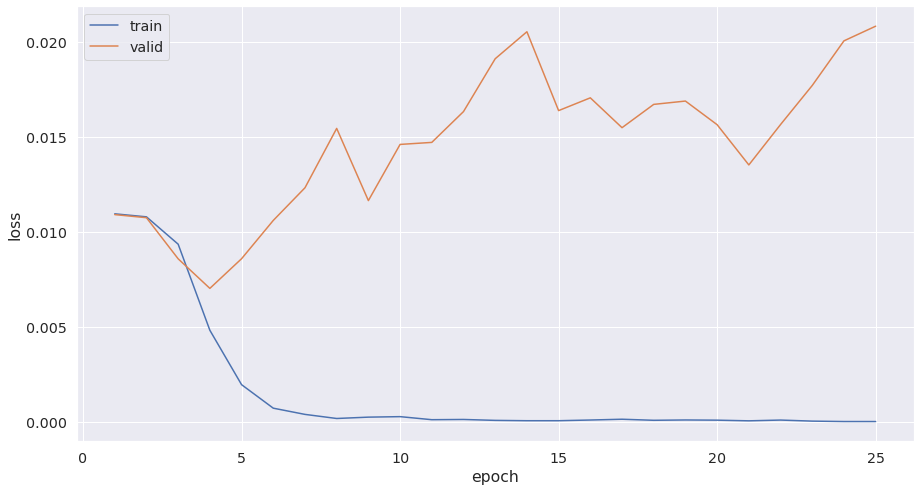

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

It seems that model is overfitting: loss on train is close to zero while loss on validation is increasing. Let's reduce `epochs` to $4$.

In [0]:
em_sz = 200
nh = 300
model = RNNBaseline(nh, emb_dim=em_sz)
model.cuda()
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()
epochs = 4

In [0]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop()

Epoch: 1, Training Loss: 0.010970963273729597, Validation Loss: 0.01090689890384674
Epoch: 2, Training Loss: 0.010694666007586888, Validation Loss: 0.010977012586593627
Epoch: 3, Training Loss: 0.009757140828881945, Validation Loss: 0.010471367144584656
Epoch: 4, Training Loss: 0.006684399534123284, Validation Loss: 0.006333266405264537
CPU times: user 1min 42s, sys: 32.7 s, total: 2min 14s
Wall time: 2min 16s


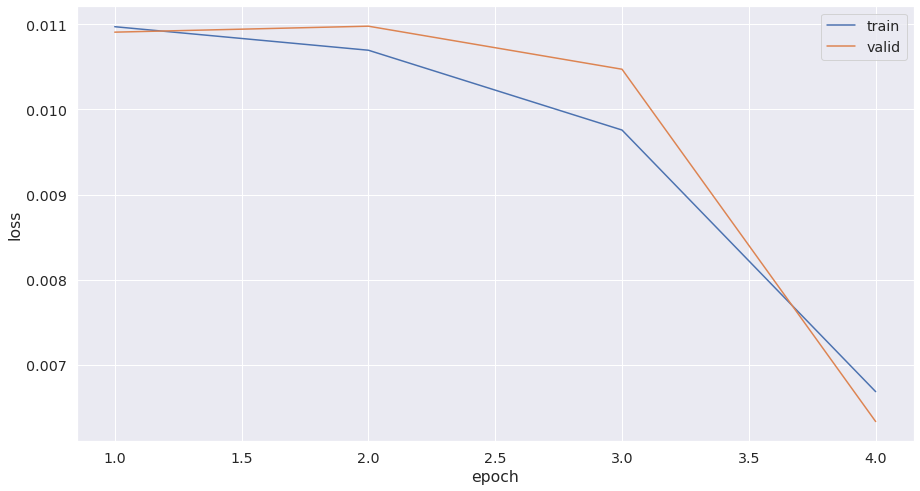

In [0]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Calculate performance of the trained model (5 points)

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [0]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.83196
0.8336415534292836
0.82944
0.8315354693828448


Write down the calculated performance

### Accuracy: 0.83196
### Precision: 0.8336
### Recall: 0.82944
### F1: 0.8315

### Experiments (10 points)

Experiment with the model and achieve better results. You can find advices [here](https://arxiv.org/abs/1801.06146). Implement and describe your experiments in details, mention what was helpful.

### 1. extra rnn layers


In [0]:
class RNNMultilayer(nn.Module):
    def __init__(self, hidden_dim, emb_dim, rnn_num_layers):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, rnn_num_layers, batch_first=False)
        self.linear = nn.Linear(hidden_dim, 1)
            
    def forward(self, seq):
        embeddings = self.emb(seq)
        # we only want last hidden state on last layer
        last_hidden = self.rnn(embeddings)[0][-1, :, :]
        # preds are outputs of linear layer BEFORE sigmoid
        preds = self.linear(last_hidden).reshape(-1)
        return preds

In [34]:
em_sz = 200
nh = 300
rnn_num_layers = 3
model = RNNMultilayer(nh, em_sz, rnn_num_layers)
model.cuda()

RNNMultilayer(
  (emb): Embedding(202628, 200)
  (rnn): GRU(200, 300, num_layers=3)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

In [0]:
epochs = 10

In [0]:
def train_loop(file_name='rnn'):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() 
        for batch in train_iter:           
            x = batch.text
            y = batch.label

            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y.float())
            loss.backward()
            opt.step()
            running_loss += loss.item()

        torch.save(model.state_dict(), f'{file_name}_{epoch}.pt')
        epoch_loss = running_loss / len(trn)
        train_loss_history.append(epoch_loss)

        val_loss = 0.0
        model.eval()
        for batch in val_iter:
            x = batch.text
            y = batch.label

            preds = model(x) 
            loss = loss_func(preds, y.float())
            val_loss += loss.item()
          
        val_loss /= len(vld)
        valid_loss_history.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
          epoch, epoch_loss, val_loss))

In [38]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop('rnn_experiment_1')

Epoch: 1, Training Loss: 0.01021124040058681, Validation Loss: 0.01080587609608968
Epoch: 2, Training Loss: 0.007040040843827384, Validation Loss: 0.008093252750237782
Epoch: 3, Training Loss: 0.0036739815503358843, Validation Loss: 0.010569500490029653
Epoch: 4, Training Loss: 0.001985971588002784, Validation Loss: 0.007020682360728582
Epoch: 5, Training Loss: 0.001111811672204307, Validation Loss: 0.007292160095771154
Epoch: 6, Training Loss: 0.0003586850888245473, Validation Loss: 0.00846038778424263
Epoch: 7, Training Loss: 0.00017411146040332304, Validation Loss: 0.011194602876901627
Epoch: 8, Training Loss: 0.0001470957445055579, Validation Loss: 0.008996007798115413
Epoch: 9, Training Loss: 0.00013150648307471005, Validation Loss: 0.016678824532032014
Epoch: 10, Training Loss: 0.0001643943406915891, Validation Loss: 0.01046142570177714
CPU times: user 3min 17s, sys: 1min, total: 4min 17s
Wall time: 4min 19s


In [39]:
# best score on validation
model.load_state_dict(torch.load('rnn_experiment_1_4.pt'))

<All keys matched successfully>

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [41]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.83332
0.7903686668060492
0.90728
0.8447986889642073


### Accuracy: 0.83332
### Precision: 0.790369
### Recall: 0.90728
### F1: 0.844799

There's only minor improvement compared to baseline.

2. It seems that model is overfitting quickly. Let's add dropout between layers of RNN. We will keep number of layers as 3.

In [0]:
class RNNDropout(nn.Module):
    def __init__(self, hidden_dim, emb_dim, dropout):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.rnn_1 = nn.GRU(emb_dim, hidden_dim, batch_first=False)
        self.rnn_2 = nn.GRU(hidden_dim, hidden_dim, batch_first=False)
        self.rnn_3 = nn.GRU(hidden_dim, hidden_dim, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, 1)
            
    def forward(self, x):
        x = self.emb(x)    
        x = self.rnn_1(x)[0]
        x = self.dropout(x)
        x = self.rnn_2(x)[0]
        x = self.dropout(x)
        last_hidden = self.rnn_3(x)[1]

        # preds are outputs of linear layer BEFORE sigmoid
        preds = self.linear(last_hidden).reshape(-1)
        return preds

In [29]:
em_sz = 200
nh = 300
dropout = 0.3
model = RNNDropout(nh, em_sz, dropout)
model.cuda()

RNNDropout(
  (emb): Embedding(201675, 200)
  (rnn_1): GRU(200, 300)
  (rnn_2): GRU(300, 300)
  (rnn_3): GRU(300, 300)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

In [0]:
epochs = 20

In [34]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop('rnn_experiment_2')

Epoch: 1, Training Loss: 6.038676365652853e-05, Validation Loss: 0.014245962285995483
Epoch: 2, Training Loss: 0.00014699682826841516, Validation Loss: 0.012214826986915431
Epoch: 3, Training Loss: 7.790159294298583e-05, Validation Loss: 0.01440979293982188
Epoch: 4, Training Loss: 0.00012075085809628945, Validation Loss: 0.012030656577522557
Epoch: 5, Training Loss: 0.0001179031374585715, Validation Loss: 0.010963162965079149
Epoch: 6, Training Loss: 0.00017796402075452664, Validation Loss: 0.011438720794084171
Epoch: 7, Training Loss: 0.00013435060294910467, Validation Loss: 0.012455340743064881
Epoch: 8, Training Loss: 6.520401284963425e-05, Validation Loss: 0.01337639878988266
Epoch: 9, Training Loss: 5.573165201307607e-05, Validation Loss: 0.011986051043123006
Epoch: 10, Training Loss: 0.0010335456123575569, Validation Loss: 0.01155550184349219
Epoch: 11, Training Loss: 0.000253022773228752, Validation Loss: 0.011562478320300579
Epoch: 12, Training Loss: 3.836047129838594e-05, Val

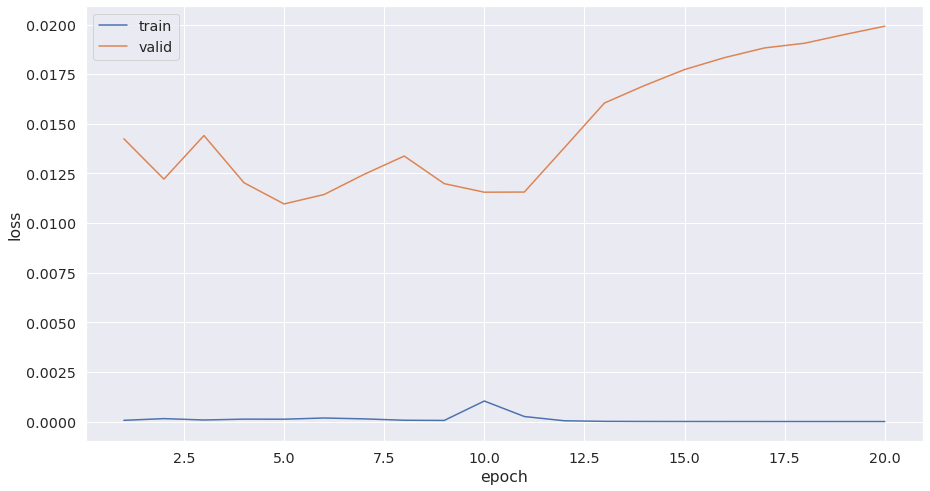

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [36]:
# best score on validation
model.load_state_dict(torch.load('rnn_experiment_2_5.pt'))

<All keys matched successfully>

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [38]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.8374
0.8134056624804934
0.87568
0.8433948453211079


### Accuracy: 0.8374
### Precision: 0.81341
### Recall: 0.87568
### F1: 0.84339

No further improvements in F1-score, accuracy increased a bit.

3. Add ReLU and batchnorm layers. The other parts are the same to second experiment.

In [0]:
class RNNBatchNorm(nn.Module):
    def __init__(self, hidden_dim, emb_dim, dropout):
        super().__init__()
        self.emb = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.rnn_1 = nn.GRU(emb_dim, hidden_dim, batch_first=False)
        self.rnn_2 = nn.GRU(hidden_dim, hidden_dim, batch_first=False)
        self.rnn_3 = nn.GRU(hidden_dim, hidden_dim, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.batchnorm_1 = nn.BatchNorm1d(emb_dim)
        self.batchnorm_2 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm_3 = nn.BatchNorm1d(hidden_dim)


        self.linear = nn.Linear(hidden_dim, 1)
            
    def forward(self, x):
        x = self.emb(x)
        # permute for batch_norm
        x = x.permute(1, 2, 0)
        x = self.batchnorm_1(x) 
        # inverse permute
        x = x.permute(2, 0, 1)
        
        x = self.rnn_1(x)[0]
        x = self.dropout(x)
        x = self.relu(x)
        x = x.permute(1, 2, 0)
        x = self.batchnorm_2(x)
        x = x.permute(2, 0, 1)


        x = self.rnn_2(x)[0]
        x = self.dropout(x)
        x = self.relu(x)
        x = x.permute(1, 2, 0)
        x = self.batchnorm_3(x)
        x = x.permute(2, 0, 1)

        last_hidden = self.rnn_3(x)[1]
        last_hidden = self.relu(last_hidden)
        last_hidden = self.dropout(last_hidden)

        # preds are outputs of linear layer BEFORE sigmoid
        preds = self.linear(last_hidden).reshape(-1)
        # make the batch second again
        return preds

In [76]:
em_sz = 200
nh = 300
dropout = 0.3
model = RNNBatchNorm(nh, em_sz, dropout)
model.cuda()

RNNBatchNorm(
  (emb): Embedding(201675, 200)
  (rnn_1): GRU(200, 300)
  (rnn_2): GRU(300, 300)
  (rnn_3): GRU(300, 300)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

In [0]:
epochs = 20

In [79]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop('rnn_experiment_3')

Epoch: 1, Training Loss: 0.009668237434114728, Validation Loss: 0.013694231311480204
Epoch: 2, Training Loss: 0.006787504548685892, Validation Loss: 0.008487483048439026
Epoch: 3, Training Loss: 0.003907989069393703, Validation Loss: 0.012144673717021942
Epoch: 4, Training Loss: 0.0020888086824544837, Validation Loss: 0.007777858434120814
Epoch: 5, Training Loss: 0.0011555199372183, Validation Loss: 0.009139527809619904
Epoch: 6, Training Loss: 0.0005504902469792536, Validation Loss: 0.009342416457335155
Epoch: 7, Training Loss: 0.00043078450355013564, Validation Loss: 0.010278432500362396
Epoch: 8, Training Loss: 0.00030477801104342297, Validation Loss: 0.01091518675138553
Epoch: 9, Training Loss: 0.0002372622469273795, Validation Loss: 0.011691534543037415
Epoch: 10, Training Loss: 0.00017547657137786571, Validation Loss: 0.012715103165308635
Epoch: 11, Training Loss: 0.00010325805340294859, Validation Loss: 0.011978138633569082
Epoch: 12, Training Loss: 0.0001399872114482735, Valida

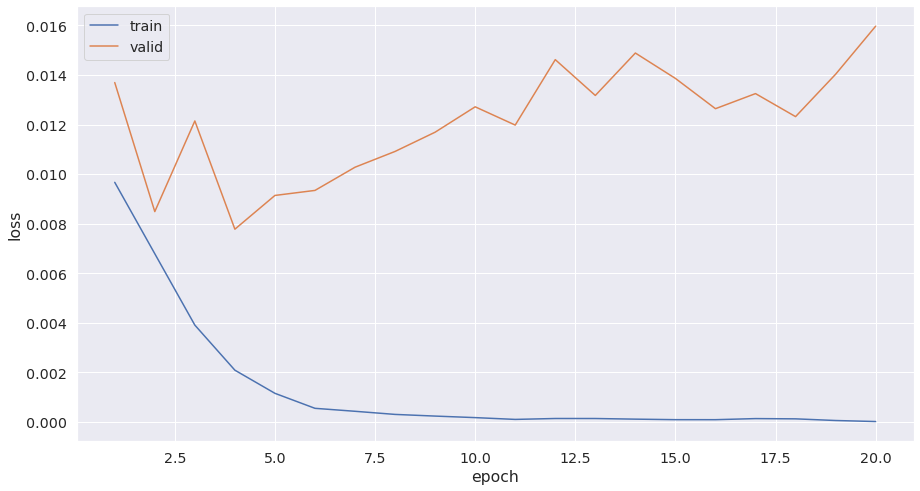

In [80]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [81]:
# best score on validation
model.load_state_dict(torch.load('rnn_experiment_3_4.pt'))

<All keys matched successfully>

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [83]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.84036
0.8276977586074097
0.85968
0.8433857866028334


### Accuracy: 0.84036
### Precision: 0.8277
### Recall: 0.85968
### F1: 0.84339

We managed to improve accuracy compared to first experiment. Overall experiments gave +0.01 to accuracy and F1-score. Probably the most important change was adding multiple layers to rnn.